In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import StratifiedKFold
import numpy as np
import random

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/train_with_features.csv')
X = df.iloc[:, 5::]
Y = df['target']

SEED = 43
random.seed(SEED)
np.random.seed(SEED)

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=SEED)

mean_encoder = TargetEncoder(random_state=SEED) 
clf = LogisticRegression(max_iter=2000, random_state=SEED)

In [3]:
mean_encoder.fit(X_train[['sentimiento', 'tiene_url']], y_train)
x_encoded = mean_encoder.fit_transform(X_train, y_train)

params = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=10, scoring='f1', cv=5, n_jobs=-1, random_state=SEED)


In [4]:
random_search.fit(x_encoded, y_train)

/home/tomy07417/data-science/ml/.venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,estimator,LogisticRegre...ndom_state=43)
,param_distributions,"{'C': [0.01, 0.1, ...], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}"
,n_iter,10
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,43
,error_score,nan


In [5]:
model = random_search.best_estimator_

# Resultado de Validación

In [6]:
x_encoded_val = mean_encoder.transform(X_val)
y_val_pred = model.predict(x_encoded_val)
accuracy_score(y_val, y_val_pred)

0.7721602101116218

# Resultados del test

In [7]:
test = pd.read_csv('./data/test_with_features.csv')
X_test = test.iloc[:, 4::]
X_test_encoded = mean_encoder.transform(X_test)
test['pred'] = model.predict(X_test_encoded)

In [8]:
submissiion = test[['id', 'pred']]
submissiion.rename(columns={'pred': 'target'}, inplace=True)
submissiion.to_csv('./submission/logistic_regression_submission.csv', index=False)

/tmp/ipykernel_1176/4238178514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissiion.rename(columns={'pred': 'target'}, inplace=True)


# Graficos del modelo

* Un punto importante a tener en cuenta que este modelo lo que le más le cuesta en predecir los casos que realmente son positivos.

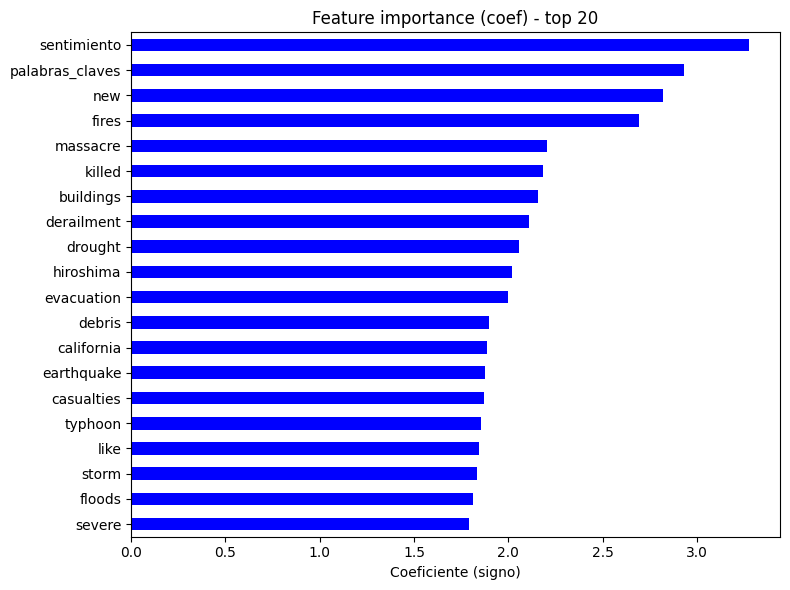

In [13]:
if hasattr(x_encoded, "columns"):
    feature_names = x_encoded.columns
else:
    feature_names = X_train.columns

coefs = model.coef_.ravel()
feat_imp = pd.Series(coefs, index=feature_names).sort_values(key=lambda s: s.abs(), ascending=False)

top_n = 20
top = feat_imp.head(top_n)

plt.figure(figsize=(8, max(4, 0.3 * len(top))))
colors = ['red' if v < 0 else 'blue' for v in top]
top.plot(kind='barh', color=colors)
plt.xlabel("Coeficiente (signo)")
plt.title(f"Feature importance (coef) - top {min(top_n, len(feat_imp))}")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

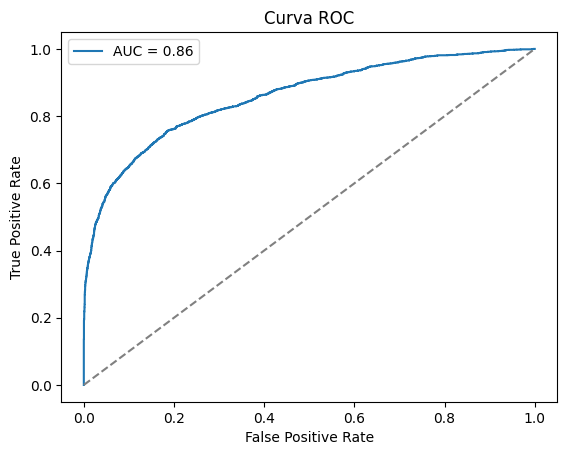

In [10]:
y_prob = model.predict_proba(x_encoded)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_train, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

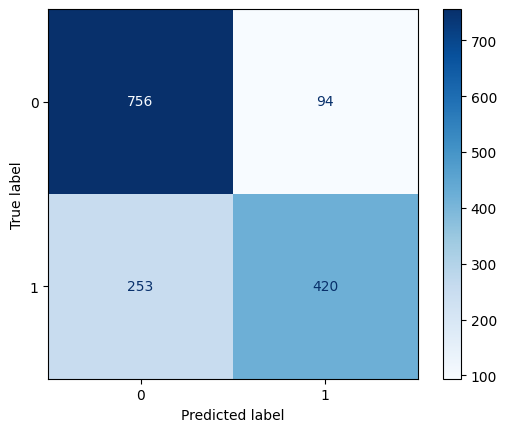

In [11]:
y_pred = model.predict(x_encoded_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred)).plot(cmap='Blues')
plt.show()